In [70]:
import rawpy
import requests
import os
from matplotlib import pyplot as plt

def pull_image(url_path = "https://www.kenrockwell.com/trips/2009-10/images/L1004432.DNG"):
    if not os.path.exists('L1004432.DNG'):
        !wget url_path
    return rawpy.imread('L1004432.DNG').raw_image

In [71]:
raw = pull_image()

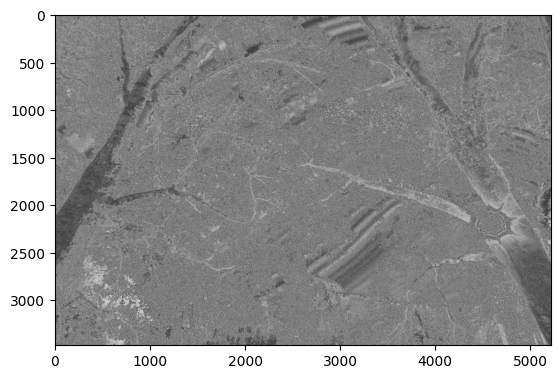

In [72]:
plt.imshow(raw.astype(dtype='uint8'), cmap="gray")

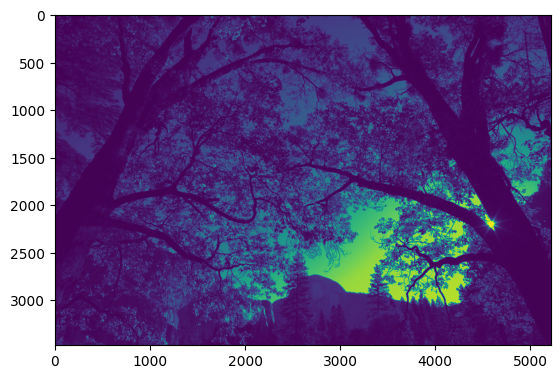

In [69]:
plt.imshow(raw)